# **Лабораторная работа №2**
Выполнилa: Ажаурова Александра Константиновна  
Группа: М8О-303Б-22


## Задача

### Цель:
Разработать модель для оценки привлекательности веб-ресурсов (веб-доменов) на основе различных факторов.

### Описание:
- У вас есть данные о 8000 веб-ресурсах, а также числовые оценки их привлекательности.
- Необходимо построить модель линейной регрессии, которая будет предсказывать **привлекательность веб-ресурса** на основе таких характеристик, как количество кликов, лайков, покупок, ошибок, жалоб, времени на сайте и дата регистрации.

### Этапы:
1. **Анализ данных**:
   - Исследовать набор данных на предмет пропусков, аномалий и распределений.
   - Построить визуализации для понимания взаимосвязей между признаками.
   
2. **Очистка данных**:
   - Обработать пропуски в данных (например, заменить на средние значения или медианы).
   - Преобразовать категориальные переменные в числовые (например, с помощью One-Hot Encoding).
   - Преобразовать даты в числовые признаки.
   
3. **Обучение модели**:
   - Обучить модель линейной регрессии на тренировочном наборе данных.
   - Проверить модель на тестовых данных и оценить метрику ошибки (MSE).

4. **Функция предсказания**:
   - Реализовать функцию `predict`, которая принимает на вход CSV-файл с данными и возвращает предсказания в виде CSV-файла с оценками привлекательности.

### Требования:
- Полный анализ данных и результаты визуализации должны быть включены в ноутбук.
- Для достижения высокой точности требуется правильно подготовить данные и применить Feature Engineering.


## Описание столбцов

| **Колонка**               | **Тип данных**  |  **Описание**                                                                 |
|---------------------------|-----------------|-------------------------------------------------------------------------------|
| `Unnamed: 0`              | int64           | Индекс строки (может быть удалён, так как дублирует нумерацию строк).         |
| `category`                | object          | Категория, к которой относится сайт.                                          |
| `clicks`                  | float64         | Количество кликов по домену.                                                  |
| `likes`                   | float64         | Количество лайков, поставленных домену.                                       |
| `buys`                    | int64           | Количество покупок, совершённых на домене.                                    |
| `4xx_errors`              | int64           | Количество ошибок с кодом 4xx за последние 6 месяцев.                         |
| `5xx_errors`              | int64           | Количество ошибок с кодом 5xx за последние 6 месяцев.                         |
| `complaints_count`        | object (строки) | Количество жалоб на домен.                                                    |
| `average_dwelltime`       | float64         | Среднее время, проведённое пользователем на домене.                           |
| `source_attractiveness`   | float64         | Привлекательность домена (целевая переменная).                                |
| `date_of_registration`    | object (строки) | Дата регистрации домена (нужно преобразовать в формат даты).                  |

Есть несколько пропусков и некорректных значений, которые нужно обработать перед построением модели.

## Решение


### 1. Загрузка и первичный анализ данных

**Цель**: Загрузить данные и изучить их структуру, типы данных, наличие пропусков и некорректных значений.

*Описание*: На данном этапе мы загружаем данные и изучаем их структуру с помощью `.info()` и `.head()`, а также проверяем наличие пропусков с помощью `.isnull().sum()`.

In [51]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [52]:
# Загрузка данных
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [53]:
# Основная информация о данных
print(train_data.info())
# Просмотр первых строк для визуального анализа
print(train_data.head())
# Проверка на пропуски
print(train_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             8000 non-null   int64  
 1   category               8000 non-null   object 
 2   clicks                 7727 non-null   float64
 3   likes                  7624 non-null   float64
 4   buys                   8000 non-null   int64  
 5   4xx_errors             8000 non-null   int64  
 6   5xx_errors             8000 non-null   int64  
 7   complaints_count       7527 non-null   object 
 8   average_dwelltime      8000 non-null   float64
 9   source_attractiveness  8000 non-null   float64
 10  date_of_registration   8000 non-null   object 
dtypes: float64(4), int64(4), object(3)
memory usage: 687.6+ KB
None
   Unnamed: 0            category     clicks     likes  buys  4xx_errors  \
0        6622                ecom  6488536.0       NaN     0       82221

### 2. Предобработка данных

**Цель**: Обработать пропуски, преобразовать категориальные переменные и даты, чтобы подготовить данные к обучению модели.

#### Шаги:

1. **Обработка пропусков**:
   - Пропуски в столбцах `clicks`, `likes`, и `complaints_count` нужно обработать (например, заполнить средними или медианными значениями).
   - Категориальный столбец `complaints_count` содержит строки, поэтому его следует привести к числовому формату.

2. **Преобразование дат**:
   - Столбец `date_of_registration` необходимо преобразовать в формат даты, а затем создать новый признак — количество дней с момента регистрации.

3. **One-Hot Encoding**:
   - Преобразовать категориальные переменные с помощью One-Hot Encoding.


In [54]:
# Переименовываемл столбец `'Unnamed: 0'` в `'ID'` и 
# устанавливаем его в качестве индекса DataFrame `train_data`.
id_column = 'ID'
train_data.rename(columns={'Unnamed: 0': id_column}, inplace=True)
train_data.set_index(id_column, inplace=True)

In [55]:
# Преобразуем complaints_count в числовой формат, заменяя некорректные значения на NaN
train_data['complaints_count'] = pd.to_numeric(train_data['complaints_count'], errors='coerce')

# Столбцы с пропусками, которые нужно обработать
columns_with_missing_values = ['clicks', 'likes', 'average_dwelltime', 'complaints_count']

# Импьютер для заполнения пропусков средними значениями
imputer = SimpleImputer(strategy='mean')

# Заполняем пропуски средними значениями в указанных столбцах
train_data[columns_with_missing_values] = imputer.fit_transform(train_data[columns_with_missing_values])

# Преобразуем столбец complaints_count в числовой формат
train_data['complaints_count'] = pd.to_numeric(train_data['complaints_count'], errors='coerce')

# Проверим результат
print(train_data[columns_with_missing_values].info())
print(train_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 6622 to 9289
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   clicks             8000 non-null   float64
 1   likes              8000 non-null   float64
 2   average_dwelltime  8000 non-null   float64
 3   complaints_count   8000 non-null   float64
dtypes: float64(4)
memory usage: 312.5 KB
None
category                 0
clicks                   0
likes                    0
buys                     0
4xx_errors               0
5xx_errors               0
complaints_count         0
average_dwelltime        0
source_attractiveness    0
date_of_registration     0
dtype: int64


In [56]:
# Преобразуем столбец date_of_registration в формат даты
train_data['date_of_registration'] = pd.to_datetime(train_data['date_of_registration'], errors='coerce')

# Создадим новый признак — количество дней с момента регистрации
train_data['days_since_registration'] = (pd.Timestamp.now() - train_data['date_of_registration']).dt.days

# Удалим оригинальный столбец с датой, если он больше не нужен
train_data.drop('date_of_registration', axis=1, inplace=True)

# Проверяем результат
print(train_data.head())
print(train_data.info())


                category     clicks          likes  buys  4xx_errors  \
ID                                                                     
6622                ecom  6488536.0  598502.743179     0       82221   
2047  information_source   874840.0   21100.000000     0       12872   
1118  information_source   571210.0   94707.000000     0           0   
4992                news    89534.0     924.000000     0         834   
9970  information_source  1043953.0  289288.000000     0       58375   

      5xx_errors  complaints_count  average_dwelltime  source_attractiveness  \
ID                                                                             
6622           0               0.0          18.450527               0.461750   
2047           0               0.0          10.721619              -0.022317   
1118        7420               0.0           1.922243               0.046396   
4992           0               0.0           2.149243              -0.093360   
9970       2026

In [57]:
# Проверяем наличие столбца complaints_count
print('complaints_count' in train_data.columns)

# Список всех столбцов
print(train_data.columns)



True
Index(['category', 'clicks', 'likes', 'buys', '4xx_errors', '5xx_errors',
       'complaints_count', 'average_dwelltime', 'source_attractiveness',
       'days_since_registration'],
      dtype='object')


In [58]:
# Проверим текущие столбцы в DataFrame
print(train_data.columns.tolist())


['category', 'clicks', 'likes', 'buys', '4xx_errors', '5xx_errors', 'complaints_count', 'average_dwelltime', 'source_attractiveness', 'days_since_registration']


In [59]:
# Определяем целевую переменную и признаки
X = train_data.drop('source_attractiveness', axis=1)
y = train_data['source_attractiveness']

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверяем размеры выборок
print(f'Размер обучающей выборки: {X_train.shape[0]}')
print(f'Размер тестовой выборки: {X_test.shape[0]}')

Размер обучающей выборки: 6400
Размер тестовой выборки: 1600


In [61]:
# Убедитесь, что данные уже закодированы с помощью One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)  # Закодируйте категориальные переменные

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Прогнозирование на тестовом наборе
y_pred = model.predict(X_test_scaled)

# Оценка модели с помощью MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Средняя квадратичная ошибка (MSE): {mse}')


Средняя квадратичная ошибка (MSE): 0.017124926078084256


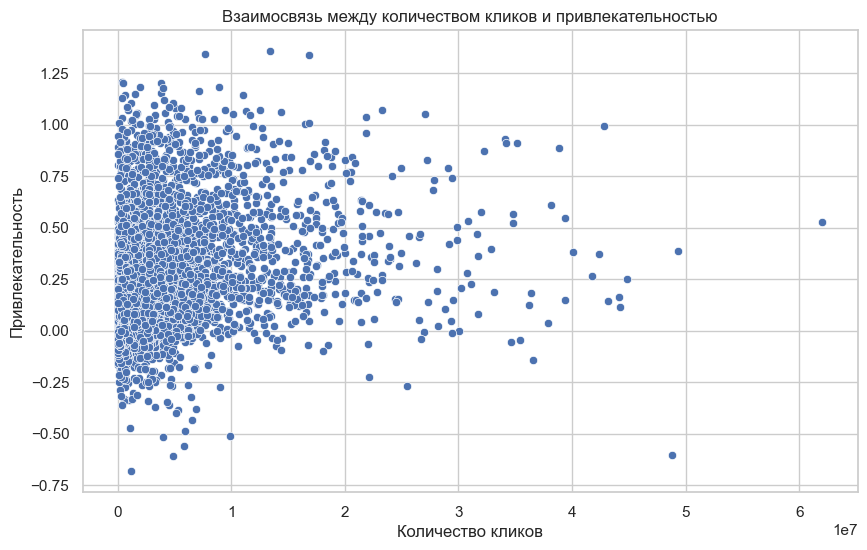

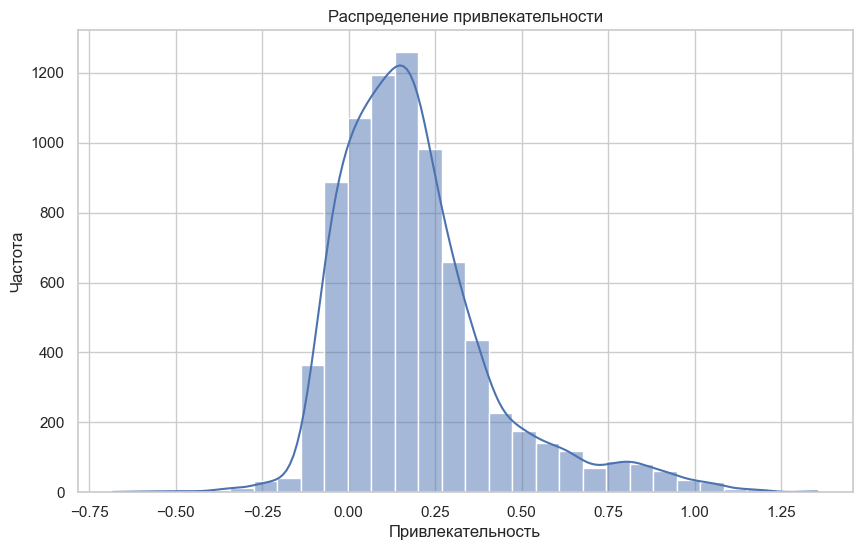

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Установим стиль графиков
sns.set(style='whitegrid')

# Визуализация зависимости 'source_attractiveness' от 'clicks'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x='clicks', y='source_attractiveness')
plt.title('Взаимосвязь между количеством кликов и привлекательностью')
plt.xlabel('Количество кликов')
plt.ylabel('Привлекательность')
plt.show()

# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(train_data['source_attractiveness'], bins=30, kde=True)
plt.title('Распределение привлекательности')
plt.xlabel('Привлекательность')
plt.ylabel('Частота')
plt.show()


In [65]:
def predict(test_file):
    # Загрузка тестовых данных
    test_data = pd.read_csv(test_file)

    # Переименовываем и устанавливаем индекс
    test_data.rename(columns={'Unnamed: 0': id_column}, inplace=True)
    test_data.set_index(id_column, inplace=True)
    
    # Преобразуем complaints_count в числовой формат, заменяя некорректные значения на NaN
    test_data['complaints_count'] = pd.to_numeric(test_data['complaints_count'], errors='coerce')

    # Обработка пропусков
    test_data[columns_with_missing_values] = imputer.transform(test_data[columns_with_missing_values])
    
    # Преобразуем столбец date_of_registration в формат даты
    test_data['date_of_registration'] = pd.to_datetime(test_data['date_of_registration'], errors='coerce')
    
    # Создаем новый признак — количество дней с момента регистрации
    test_data['days_since_registration'] = (pd.Timestamp.now() - test_data['date_of_registration']).dt.days
    test_data.drop('date_of_registration', axis=1, inplace=True)
    
    # One-Hot Encoding для тестовых данных
    test_data = pd.get_dummies(test_data, drop_first=True)
    
    # Приведение к тем же признакам, что и в обучающем наборе
    missing_cols = set(X.columns) - set(test_data.columns)
    for col in missing_cols:
        test_data[col] = 0
    test_data = test_data[X.columns]

    # Стандартизация тестовых данных
    test_data_scaled = scaler.transform(test_data)

    # Предсказание
    y_predict = model.predict(test_data_scaled)

    # Формирование файла submission.csv
    submission = pd.DataFrame({"source_attractiveness": y_predict})
    submission.to_csv('submission.csv', index_label="ID")
    print("Файл submission.csv успешно создан.")


In [66]:
## Submit
predict('test.csv')  # Убедитесь, что test.csv находится в той же папке, что и ноутбук.


Файл submission.csv успешно создан.
